In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['y_train.csv', 'sample_submission.csv', 'X_test.csv', 'X_train.csv']


In [2]:
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import itertools
from sklearn.metrics import *

In [21]:
X_train = pd.read_csv("../input/X_train.csv")
X_test = pd.read_csv("../input/X_test.csv")
y_train = pd.read_csv("../input/y_train.csv")
sub = pd.read_csv("../input/sample_submission.csv")

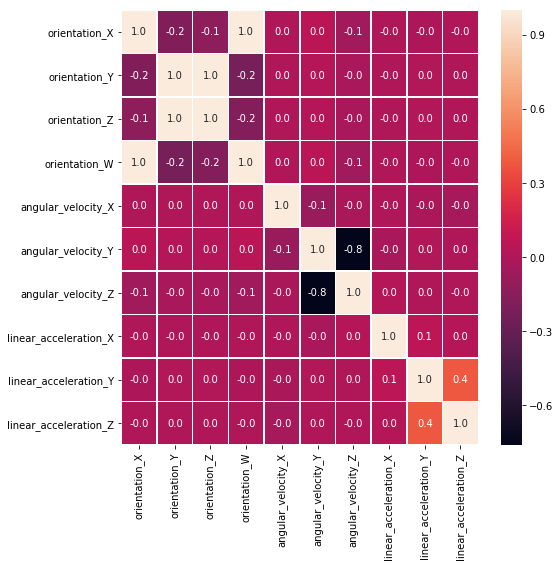

In [4]:
# https://www.kaggle.com/jesucristo/1-smart-robots-complete-notebook-0-73/notebook
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(X_train.iloc[:,3:].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [5]:
X_train.columns

Index(['row_id', 'series_id', 'measurement_number', 'orientation_X',
       'orientation_Y', 'orientation_Z', 'orientation_W', 'angular_velocity_X',
       'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X',
       'linear_acceleration_Y', 'linear_acceleration_Z'],
      dtype='object')

In [22]:
def fe(data):
    
    df = pd.DataFrame()
    data['totl_anglr_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 + data['angular_velocity_Z']**2)** 0.5
    data['totl_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 +data['linear_acceleration_Z'])**0.5
    data['totl_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 + data['orientation_Z'])**0.5
    data['acc_vs_vel'] = data['totl_linr_acc'] / data['totl_anglr_vel']
    
   # data['totalOr'] = data['orientation_X'] + data['orientation_Y']+ data['orientation_Z'] + data['orientation_W']
    
   # data['or_vs_acc'] = data['totalOr'] / data['totl_linr_acc']
   
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_median'] = data.groupby(['series_id'])[col].median()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_skew'] = data.groupby(['series_id'])[col].skew()           
        df[col + '_range'] = df[col + '_max'] - df[col + '_min']
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_mean_abs_chg'] = data.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[col + '_abs_max'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_min'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        #df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2

    return df

In [23]:
%%time
X_train = fe(X_train)
print(X_train.shape)
X_test = fe(X_test)
print(X_test.shape)


(3810, 154)
(3816, 154)
CPU times: user 1min 56s, sys: 400 ms, total: 1min 56s
Wall time: 1min 56s


In [ ]:
print(X_train.shape)

In [ ]:
print(X_test.shape)

In [107]:
le = LabelEncoder()
y_train['surface'] = le.fit_transform(y_train['surface'])

In [112]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train['surface']),
                                                 y_train['surface'])

class_weights

array([ 2.23985891,  0.54343175,  1.16620753, 20.15873016,  1.37445887,
        0.57832423,  1.42536476,  0.82360571,  0.697419  ])

In [113]:

cw = dict(zip(y_train['surface'], class_weights))
cw
#class_weights[1]


{2: 2.239858906525573,
 1: 0.8236057068741893,
 6: 1.3744588744588744,
 7: 0.5783242258652095,
 5: 1.425364758698092,
 4: 0.6974190005491488}

In [25]:
X_train.fillna(0, inplace = True)
X_test.fillna(0, inplace = True)
X_train.replace(-np.inf, 0, inplace = True)
X_train.replace(np.inf, 0, inplace = True)
X_test.replace(-np.inf, 0, inplace = True)
X_test.replace(np.inf, 0, inplace = True)

In [101]:
def k_folds(X, y, X_test, k):
    folds = StratifiedKFold(n_splits = k, shuffle=True, random_state=2018)
    #y_test = np.zeros((X_test.shape[0], 9))
    y_test = np.zeros((X_test_1.shape[0], 9))    
    y_oof = np.zeros((X.shape[0]))
    score = 0
    for i, (train_idx, val_idx) in  enumerate(folds.split(X, y)):
        clf =  RandomForestClassifier(n_estimators = 1500, n_jobs = -1,class_weight=cw )
        #clf.fit(X_train.iloc[train_idx], y[train_idx])        
        clf.fit(X_train_1.iloc[train_idx], y[train_idx])    
        print(clf.fit)
        y_oof[val_idx] = clf.predict(X.iloc[val_idx])
        #y_test += clf.predict_proba(X_test) / folds.n_splits
        y_test += clf.predict_proba(X_test_1) / folds.n_splits        
        score += clf.score(X.iloc[val_idx], y[val_idx])
        print('Fold: {} score: {}'.format(i,clf.score(X.iloc[val_idx], y[val_idx])))
        
        print('*****************************')
        #importance = pd.Series(clf.feature_importances_,index=X_train.iloc[train_idx].columns).sort_values(ascending=False)
        #print(importance)
        #print(importance.nlargest(100))
        #plt.show()
        
    print('*****************************')        
    print('Avg Accuracy', score / folds.n_splits) 
        
    return y_oof, y_test 

In [70]:
#df1 = df.iloc[:,0:2]
X_train_1 = X_train[['orientation_X_mean', 'orientation_X_max', 'orientation_W_median', 'linear_acceleration_Y_mean_abs_chg', 'orientation_W_mean', 'orientation_W_max',
'orientation_W_min', 'linear_acceleration_Z_mean_abs_chg', 'orientation_Z_abs_min', 'orientation_X_abs_max', 'orientation_Z_abs_max',
'orientation_X_abs_min', 'linear_acceleration_X_mean_abs_chg', 'orientation_Y_abs_min', 'linear_acceleration_X_std', 'orientation_Y_abs_max',
'orientation_W_abs_max', 'linear_acceleration_Z_std', 'orientation_W_abs_min', 'angular_velocity_Y_mean_abs_chg', 'totl_xyz_mean', 'totl_xyz_min',
'totl_xyz_abs_min', 'totl_xyz_abs_max', 'totl_xyz_max', 'orientation_Z_min', 'totl_xyz_median', 'linear_acceleration_X_range',
'orientation_Z_mean_abs_chg', 'totl_linr_acc_std', 'totl_anglr_vel_std', 'angular_velocity_Y_median', 'totl_anglr_vel_range', 'totl_anglr_vel_abs_max',
'totl_xyz_mean_abs_chg', 'totl_anglr_vel_mean', 'angular_velocity_X_max', 'totl_anglr_vel_max', 'totl_anglr_vel_median', 'angular_velocity_X_abs_max',
'angular_velocity_Z_max', 'acc_vs_vel_median', 'angular_velocity_Z_abs_max', 'acc_vs_vel_mean', 'linear_acceleration_Y_abs_max',
'angular_velocity_Y_maxtoMin', 'orientation_X_mean_abs_chg', 'linear_acceleration_Y_max', 'acc_vs_vel_std', 'angular_velocity_Y_min',
'angular_velocity_Y_abs_max', 'linear_acceleration_Y_abs_min', 'orientation_W_mean_abs_chg', 'acc_vs_vel_max', 'acc_vs_vel_abs_max',
'angular_velocity_Z_range', 'totl_linr_acc_median', 'orientation_Y_mean_abs_chg', 'orientation_X_median', 'orientation_X_min', 'orientation_Z_mean',
'orientation_Z_median', 'linear_acceleration_Z_range', 'orientation_Z_max', 'angular_velocity_Y_max', 'angular_velocity_Z_mean_abs_chg',
'angular_velocity_Y_mean', 'angular_velocity_X_min', 'orientation_X_range', 'acc_vs_vel_range', 'orientation_Y_range', 'orientation_Y_std',
'totl_linr_acc_mean'
]].copy()
X_train_1.shape

(3810, 73)

In [71]:
X_test_1 = X_test[['orientation_X_mean', 'orientation_X_max', 'orientation_W_median', 'linear_acceleration_Y_mean_abs_chg', 'orientation_W_mean', 'orientation_W_max',
'orientation_W_min', 'linear_acceleration_Z_mean_abs_chg', 'orientation_Z_abs_min', 'orientation_X_abs_max', 'orientation_Z_abs_max',
'orientation_X_abs_min', 'linear_acceleration_X_mean_abs_chg', 'orientation_Y_abs_min', 'linear_acceleration_X_std', 'orientation_Y_abs_max',
'orientation_W_abs_max', 'linear_acceleration_Z_std', 'orientation_W_abs_min', 'angular_velocity_Y_mean_abs_chg', 'totl_xyz_mean', 'totl_xyz_min',
'totl_xyz_abs_min', 'totl_xyz_abs_max', 'totl_xyz_max', 'orientation_Z_min', 'totl_xyz_median', 'linear_acceleration_X_range',
'orientation_Z_mean_abs_chg', 'totl_linr_acc_std', 'totl_anglr_vel_std', 'angular_velocity_Y_median', 'totl_anglr_vel_range', 'totl_anglr_vel_abs_max',
'totl_xyz_mean_abs_chg', 'totl_anglr_vel_mean', 'angular_velocity_X_max', 'totl_anglr_vel_max', 'totl_anglr_vel_median', 'angular_velocity_X_abs_max',
'angular_velocity_Z_max', 'acc_vs_vel_median', 'angular_velocity_Z_abs_max', 'acc_vs_vel_mean', 'linear_acceleration_Y_abs_max',
'angular_velocity_Y_maxtoMin', 'orientation_X_mean_abs_chg', 'linear_acceleration_Y_max', 'acc_vs_vel_std', 'angular_velocity_Y_min',
'angular_velocity_Y_abs_max', 'linear_acceleration_Y_abs_min', 'orientation_W_mean_abs_chg', 'acc_vs_vel_max', 'acc_vs_vel_abs_max',
'angular_velocity_Z_range', 'totl_linr_acc_median', 'orientation_Y_mean_abs_chg', 'orientation_X_median', 'orientation_X_min', 'orientation_Z_mean',
'orientation_Z_median', 'linear_acceleration_Z_range', 'orientation_Z_max', 'angular_velocity_Y_max', 'angular_velocity_Z_mean_abs_chg',
'angular_velocity_Y_mean', 'angular_velocity_X_min', 'orientation_X_range', 'acc_vs_vel_range', 'orientation_Y_range', 'orientation_Y_std',
'totl_linr_acc_mean'
]].copy()
X_test_1.shape

(3816, 73)

In [114]:
%%time
#y_oof, y_test = k_folds(X_train, y_train['surface'], X_test, k= 2)
y_oof, y_test = k_folds(X_train_1, y_train['surface'], X_test_1, k= 11)

<bound method BaseForest.fit of RandomForestClassifier(bootstrap=True,
            class_weight={2: 2.239858906525573, 1: 0.8236057068741893, 6: 1.3744588744588744, 7: 0.5783242258652095, 5: 1.425364758698092, 4: 0.6974190005491488},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)>
Fold: 0 score: 0.8911174785100286
*****************************
<bound method BaseForest.fit of RandomForestClassifier(bootstrap=True,
            class_weight={2: 2.239858906525573, 1: 0.8236057068741893, 6: 1.3744588744588744, 7: 0.5783242258652095, 5: 1.425364758698092, 4: 0.6974190005491488},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, mi

In [62]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_oof,y_train['surface'])
#accuracy_score(y_oof,y_train['surface'])

array([[155,   5,   0,   0,   4,   5,   2,   2,   7],
       [  8, 671,  13,   0,  20,  11,   1,  19,  22],
       [  1,  10, 293,   0,   4,   8,   1,   5,   9],
       [  0,   0,   0,  15,   0,   0,   1,   0,   1],
       [  3,  14,   1,   0, 271,   5,   0,   4,   0],
       [  2,  20,  11,   1,   1, 662,   3,   8,  27],
       [  3,   9,   1,   2,   1,  17, 283,   5,  13],
       [  1,  12,  10,   0,   0,   3,   1, 460,  22],
       [ 16,  38,  34,   3,   7,  21,   5,  11, 506]])

In [76]:
y_test = np.argmax(y_test, axis=1)
submission = pd.read_csv(os.path.join("../input/",'sample_submission.csv'))
submission['surface'] = le.inverse_transform(y_test)
submission.to_csv('submission_less_feature_2.csv', index=False)


In [77]:
submission.head(10)

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,tiled
3,3,carpet
4,4,soft_tiles
5,5,concrete
6,6,soft_pvc
7,7,concrete
8,8,wood
9,9,wood
